# Setting up PySpark enviornment

In [1]:
from pyspark import SparkContext
sc = SparkContext()

In [2]:
from pyspark import SQLContext
sqlContext = SQLContext(sc)

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.types import *  

# Loading in data from HDFS

Now that the PySpark enviornment has been setup, the next step is to upload the data from HDFS:

In [6]:
green_2013 = sqlContext.read.csv("hdfs://namenode:8020/am2786/***/Taxi_2013_green.csv", header=True,inferSchema=True)

In [7]:
green_2014 = sqlContext.read.csv("hdfs://namenode:8020/am2786/***/Taxi_2014_green.csv", header=True,inferSchema=True)

In [8]:
green_2015 = sqlContext.read.csv("hdfs://namenode:8020/am2786/***/Taxi_2015_green.csv", header=True,inferSchema=True)

In [9]:
yellow_2013 = sqlContext.read.csv("hdfs://namenode:8020/am2786/***/Taxi_2013_yellow.csv", header=True,inferSchema=True)

In [10]:
yellow_2014 = sqlContext.read.csv("hdfs://namenode:8020/am2786/***/Taxi_2014_yellow.csv", header=True,inferSchema=True)

In [11]:
yellow_2015 = sqlContext.read.csv("hdfs://namenode:8020/am2786/***/Taxi_2015_yellow.csv", header=True,inferSchema=True)

## Outlier and Incorrect Data Entry Detection

With any *real* dataset you can bet your last dollar that there will be some data that has been input incorrectly. In the case of our taxi data, this can be:

- Recording the incorrect number of passengers
- Error with the taxi meter that puts an impossibly *low* or *high* fare

Our safest course of action is to get rid of these incorrect taxi trips. In the case of the first issue pertaining to the number of passengers, we can get rid of any trips that have 0 passengers recorded, as this is impossible. For the fare amount we can set some minimum threshold for the fare amount where any trip with a fare less than that is thrown away. Doing a quick Google search reveals that taxis in New York have a $2.50 minimum, meaning that as soon as you step in that is what you are charged. We can use this as our minimum fare threshold. 

In [12]:
def taxi_data_cleaner(data):
    
    # Getting rid of rides with 0 passengers
    data = data.filter(data.Passenger_count > 0)
    
    # Getting rid of rides with impossibly low fares
    data = data.filter(data.Fare_amount > 1.)
    
    #Making a feature which measures the % a driver was tipped 
    data = data.withColumn("Tip_percentage", 100.*(col("Tip_amount")/(col("Total_amount") - col("Tip_amount"))))
    
    # Adding columns that give the month , day of the week and hour of pickups and dropoffs
    data = data.withColumn("pickup_dayofweek", date_format('pickup_datetime', 'u'))
    data = data.withColumn("dropoff_dayofweek", date_format('dropoff_datetime', 'u'))
    data = data.withColumn("pickup_month", month('pickup_datetime'))
    data = data.withColumn("dropoff_month", month('dropoff_datetime'))
    data = data.withColumn("pickup_hour", hour('pickup_datetime'))
    data = data.withColumn("dropoff_hour", hour('dropoff_datetime'))
    return(data)

In [13]:
green_2013_cleaned   = taxi_data_cleaner(green_2013)

In [14]:
green_2014_cleaned   = taxi_data_cleaner(green_2014)

In [15]:
green_2015_cleaned   = taxi_data_cleaner(green_2015)

In [16]:
yellow_2013_cleaned  = taxi_data_cleaner(yellow_2013)

In [17]:
yellow_2014_cleaned  = taxi_data_cleaner(yellow_2014)

In [18]:
yellow_2015_cleaned  = taxi_data_cleaner(yellow_2015)

# Binning data into time series

Now we move on to counting the number of trips each day for the 6 datasets. I made my own function to do this, which just groups the data by date.

In [19]:
def time_binner(data):
    data = data.withColumn("part_date", substring(col("pickup_datetime"), 1, 10))
    data_binned = data.groupby("part_date").count().sort("part_date", ascending = True)
    data_binned = data_binned.filter(data_binned.part_date != 'null')
    return(data_binned)

In [20]:
green_2013_clean_time_bins = time_binner(green_2013_cleaned)

In [21]:
green_2014_clean_time_bins = time_binner(green_2014_cleaned)

In [22]:
green_2015_clean_time_bins = time_binner(green_2015_cleaned)

In [23]:
yellow_2013_clean_time_bins = time_binner(yellow_2013_cleaned)

In [24]:
yellow_2014_clean_time_bins = time_binner(yellow_2014_cleaned)

In [25]:
yellow_2015_clean_time_bins = time_binner(yellow_2015_cleaned)

# Combining 2013, 2014 and 2015 times series into one

Cool. We currently have 6 time series. Both green and yellow taxis have 3 times series corresponding to the years 2013, 2014 and 2015. We need to combine these using the PySpark function `.union`

In [26]:
green_time_bins  = green_2013_clean_time_bins.union(green_2014_clean_time_bins)
yellow_time_bins = yellow_2013_clean_time_bins.union(yellow_2014_clean_time_bins)

In [27]:
green_time_series  = green_time_bins.union(green_2015_clean_time_bins).toPandas()
yellow_time_series  = yellow_time_bins.union(yellow_2015_clean_time_bins).toPandas()

# Making a plot of the results
Whew now we can plot! This notebook takes a while to run, so I advise saving the time series as their own csv files so that you don't have to import all 450 million+ rows of data each time.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

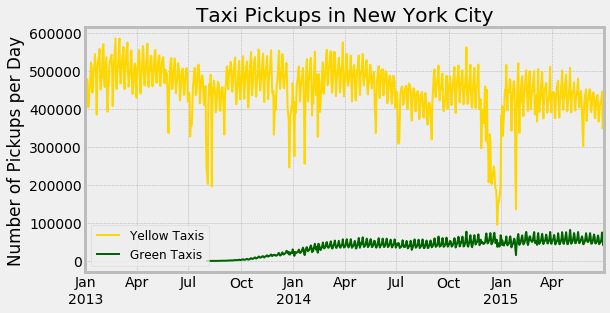

In [32]:
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

lw = 2

plt.style.use('bmh')


plt.figure(figsize = (9,5))
plt.subplots_adjust(left = 0.15, bottom = 0.2)
ax = plt.axes()
yellow_time_series.plot(ax = ax, color = 'gold', label = 'Yellow Taxis', lw = lw)
green_time_series.plot(ax = ax, color = 'darkgreen', label = 'Green Taxis', lw = lw) 
plt.title('Taxi Pickups in New York City')
plt.ylabel('Number of Pickups per Day')
plt.xlabel('')
plt.legend(loc = 'lower left', fontsize = 12)

plt.savefig('Final1.png', dpi = 800)

## Section 5. How much will taxi ridership change in the future?
Nice now it's time to predict the future. The Python package `fbprophet` is great at this however, as someone who likes to turn every little aspect of their plot I've found the package lacking in its ability to let you do this. We start by importing the package then fitting our model to the time series data.  

In [60]:
from fbprophet import Prophet

### Forecasting for green taxis

In [61]:
# Forecasting
green_model = Prophet(interval_width=0.95)
green_model.fit(green_time_series)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Now that the model's been made we looj at the predictions:

In [62]:
green_future_dates = green_model.make_future_dataframe(periods=60)
green_forecast = green_model.predict(green_future_dates)

Text(0.5,10.24,'')

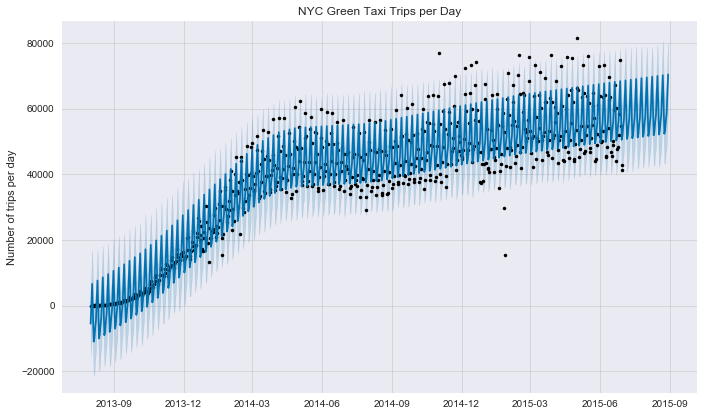

In [63]:
plt.style.use('seaborn')
green_model.plot(green_forecast,uncertainty=True)
plt.title('NYC Green Taxi Trips per Day')
plt.ylabel('Number of trips per day')
plt.xlabel('')

We can also look at the indivkidual componenents to the model:

Text(12.965,0.5,'weekly')

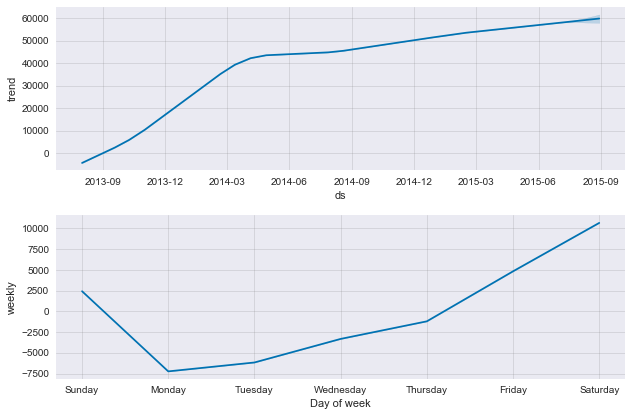

In [64]:

green_model.plot_components(green_forecast)
plt.title('')
plt.ylabel('weekly')


### Forecasting for yellow taxis
We now run the same analysis for yellow taxis:

In [65]:
# Forecasting
yellow_model = Prophet(interval_width=0.95)
yellow_model.fit(yellow_time_series)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [66]:
yellow_future_dates = yellow_model.make_future_dataframe(periods=60)
yellow_forecast = yellow_model.predict(yellow_future_dates)

Text(0.5,10.24,'')

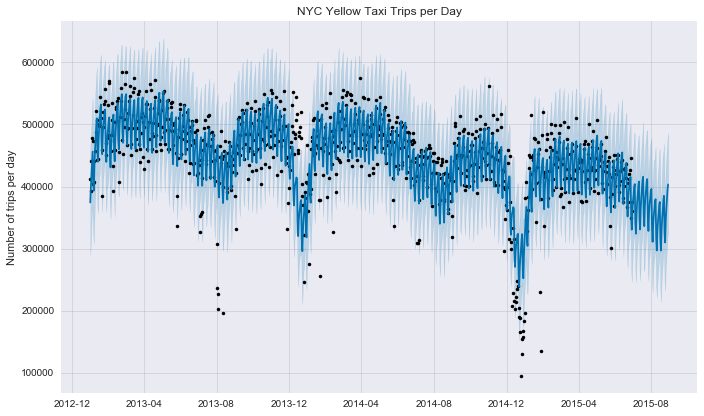

In [67]:
plt.style.use('seaborn')
yellow_model.plot(yellow_forecast,uncertainty=True)
plt.title('NYC Yellow Taxi Trips per Day')
plt.ylabel('Number of trips per day')
plt.xlabel('')

Text(7.34,0.5,'weekly')

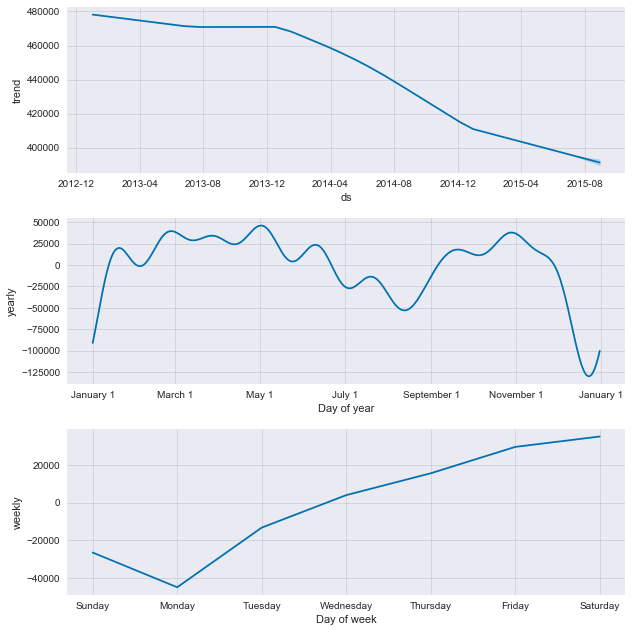

In [58]:
yellow_model.plot_components(yellow_forecast)
plt.title('')
plt.ylabel('weekly')
